# Mortgage Stressor Notebook

| Rhys Whitley  | 
| ------------- |
| **Created:** 18 Aug 2019   | 

Does what it says on the packet; i.e. simply determines all possible outcomes for a home loan under a given repayments structure.

In [64]:
import pandas as pd
import numpy as np
from datetime import datetime

from joblib import Parallel, delayed

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
    
%matplotlib inline

Define a function that we can use to _stress test_ the mortgage repayments for a given loan, with some deposit for an arbitrary starting date. The life of the loan, initial interest rate and rate of inflation are hard-wired unless set otherwise.

In [12]:
def mortgage_repayment(cost, deposit, installment, life_loan=30, int_start=0.03, inflate=0.02):
    """
    Simulates the repayment of a loan, given a deposit and ongoing monthly installment rate.
    Can change the life of the loan, starting interest rate and rate of inflation.
    """
    start_date = datetime.now()
    end_date = start_date + pd.DateOffset(years=life_loan)
    loan_life = pd.date_range(start_date, end_date, freq='M')
    
    # define record lists
    loan_amount = [cost-deposit]
    income_amount = [installment]
    int_record = [int_start]
    
    # simulate
    int_rate = int_start
    for t in range(1, len(loan_life)):
        
        # random walk interest rate
        int_rate = int_rate + np.random.normal(0, 0.005) if np.random.random() < 0.25 else int_rate
        # we assume that long-term the bank will cup at a 0.5% rate
        int_rate = max(0.005, int_rate)
        # random portion of fortnightly income used to down-pay the loan
        portion = np.random.uniform(0.6, 1)
   
        # compound loan and repayment
        loan_adj = loan_amount[t-1] + loan_amount[t-1]*int_rate/12
        income_adj = income_amount[t-1] + income_amount[t-1]*portion*inflate/12

        # add to record
        loan_amount.append(max(0, loan_adj - income_adj))
        income_amount.append(income_adj)
        int_record.append(int_rate)

    return loan_life, loan_amount, int_record

Do a test case - make sure the function works.

In [43]:
tseries, morts, ints = mortgage_repayment(1e6, 2e5, 5e3)

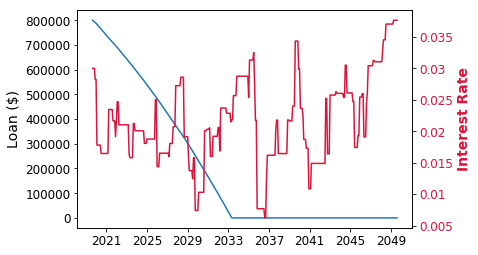

In [44]:
ax1 = plt.subplot(111)
ax2 = ax1.twinx()
ax1.plot(tseries, morts, label='Repayment')
ax2.plot(tseries, ints, color='crimson', label='Interest Rate')
ax1.set_ylabel("Loan ($)")
ax2.set_ylabel("Interest Rate", color='crimson', fontweight='bold')
ax2.set_yticklabels(ax2.get_yticks(), color='crimson');

Now define some other functions to create a simulation of replicate interest rate universes that the loan and repayment structure is exposed to over $X$ years (typically 30).

In [67]:
def mortgage_wrapper(*args, **kwargs):
    _, out, _ = mortgage_repayment(*args, **kwargs)
    return out

def simulate_mortgage(*args, simlen=5000, **kwargs):
    """
    Does the simulation for different interest rate realisations over the life of the loan.
    """
    sim = Parallel(n_jobs=-1)(delayed(mortgage_wrapper)(*args, **kwargs) for x in range(simlen))
    sim = np.array(sim)
    sim_mean = sim.mean(axis=0)
    repay_years = np.sum(sim > 0, axis=1)/12
    start_date = datetime.now()
    default_chance = sum(sim.T[-1,:] > 0)/sim.shape[0]*100
    
    time_axis = pd.date_range(start_date, periods=sim.shape[1], freq='M')

    gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1], wspace=0.05)
    fig = plt.figure(figsize=(15, 5))
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])

    ax1.plot(time_axis, sim.T, color='cornflowerblue', alpha=0.1)
    ax1.plot(time_axis, sim_mean, color='gold', lw=3, label='Average')
    
    custom_lines = [Line2D([0],[0], color='cornflowerblue', lw=1),
                    Line2D([0],[0], color='gold', lw=3)]
    
    ax1.legend(custom_lines, ["Realisation", "Mean"])
    ax1.set_ylim([0, (args[0]-args[1])*1.1])
    ax1.set_ylabel("Loan ($)")
    ax1.set_xlabel("Repayment Year")
    ax1.set_title("Chance of default: {:.2f}%".format(default_chance), fontweight='bold', y=0.9)
    
    ax2.hist(repay_years, bins=100, density=True, color='cornflowerblue')
    mean_ = np.mean(repay_years)
    q05_ = np.percentile(repay_years, q=5)
    q95_ = np.percentile(repay_years, q=95)
    ax2.axvline(mean_, color='gold', lw=3, label=r'  $\mu$ = {:.2f}'.format(mean_))
    ax2.axvline(q05_, color='crimson', lw=1.5, ls='--', label=r'Q05 = {:.2f}'.format(q05_))
    ax2.axvline(q95_, color='crimson', lw=1.5, ls='-.', label=r'Q95 = {:.2f}'.format(q95_))
    ax2.legend()
    ax2.set_xlim([0, 31])
    ax2.set_xlabel("Years to pay off")
    ax2.set_yticklabels([])
    
    plt.rc('axes', titlesize=12)    # fontsize of the axes title
    plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=12)   # fontsize of the tick labels
    plt.rc('ytick', labelsize=12)   # fontsize of the tick labels
    plt.rc('legend', fontsize=12)   # legend fontsize
    
    fig.suptitle("Sale Price: ${:,.0f} | Deposit: ${:,.0f} | Monthly Installment: ${:,.0f}".format(*args[:3]), fontsize=14)
    plt.show()

Test one simulation

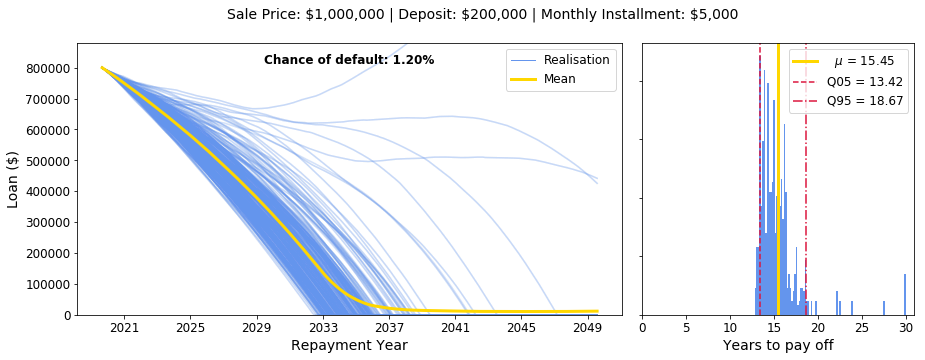

CPU times: user 2.02 s, sys: 77.1 ms, total: 2.1 s
Wall time: 9.36 s


In [68]:
%%time
simulate_mortgage(1e6, 2e5, 5000, simlen=1000)

Now do this for a range of sale prices and see how stable a monthly repayment scheme of \$5000 with a deposit of \$500,000 is over 30 years.

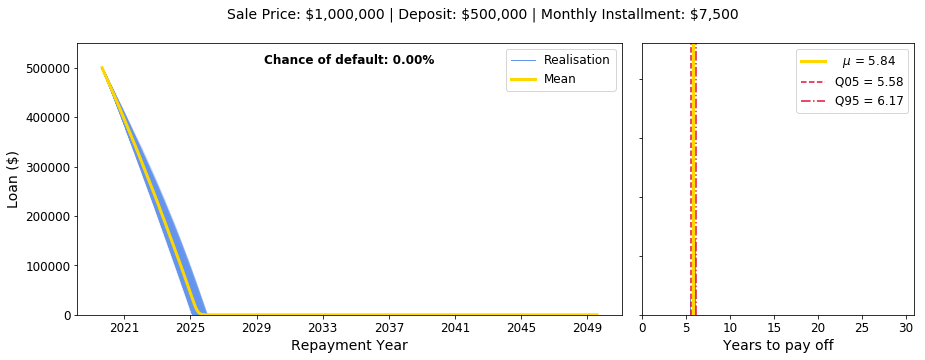

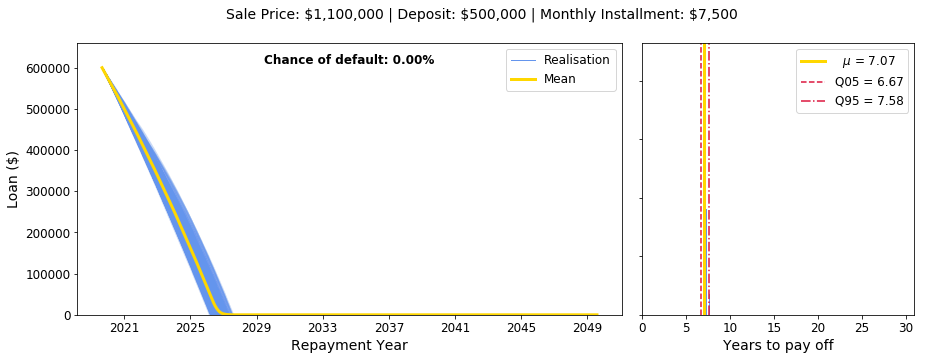

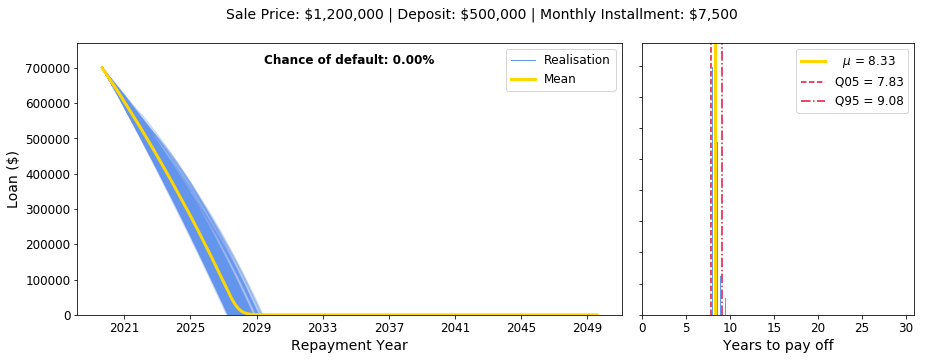

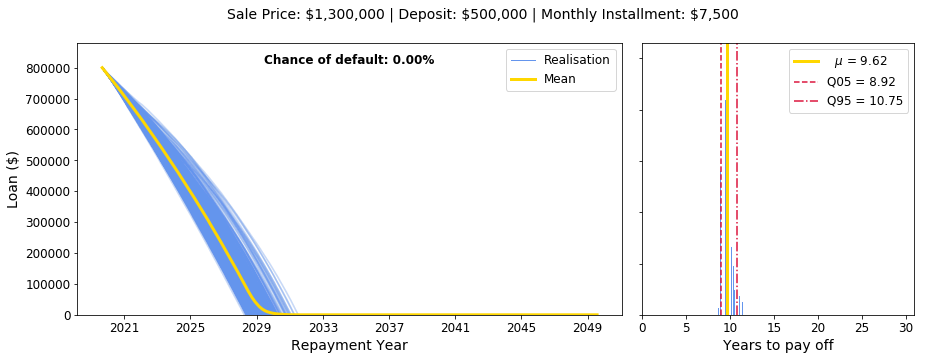

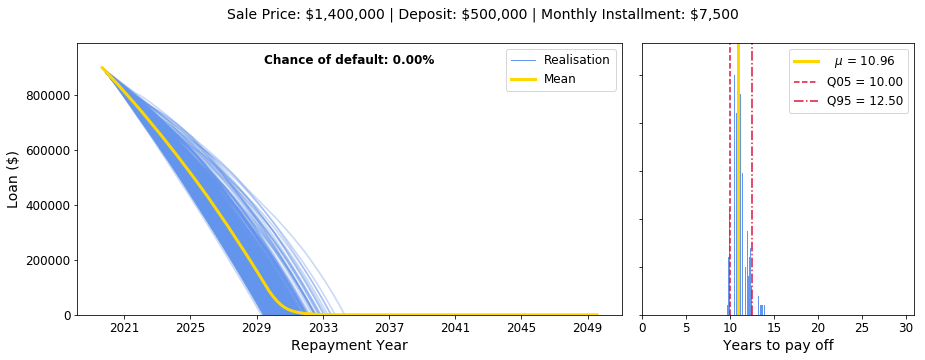

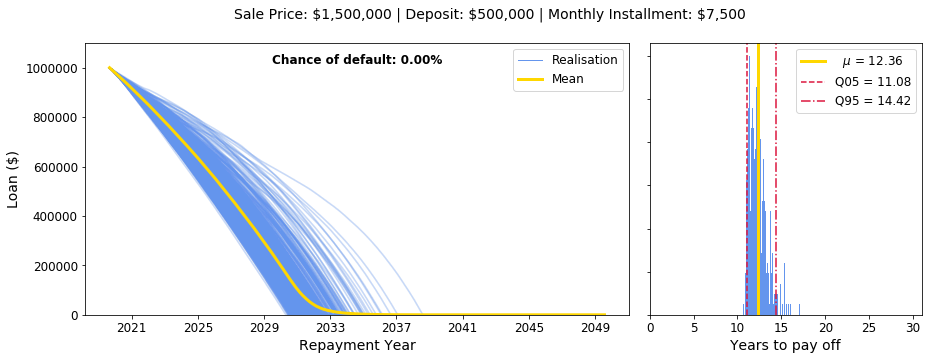

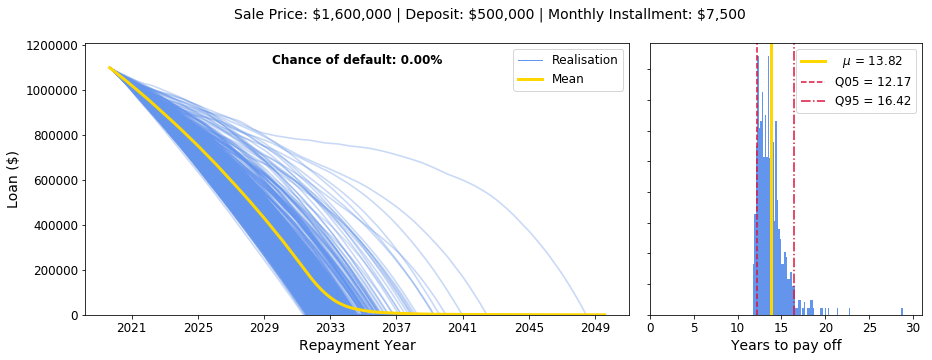

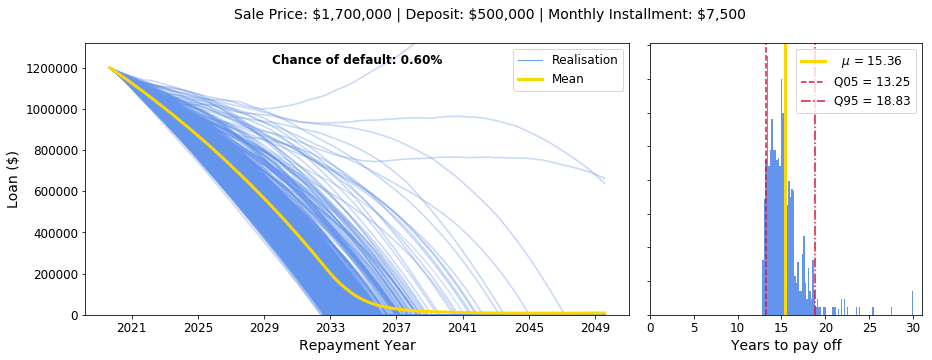

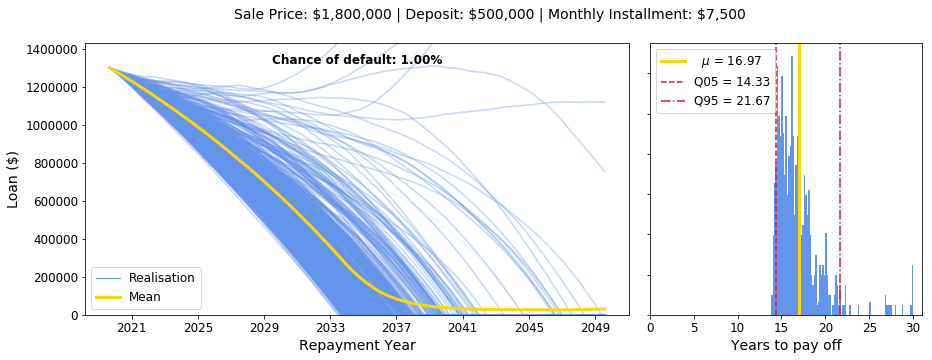

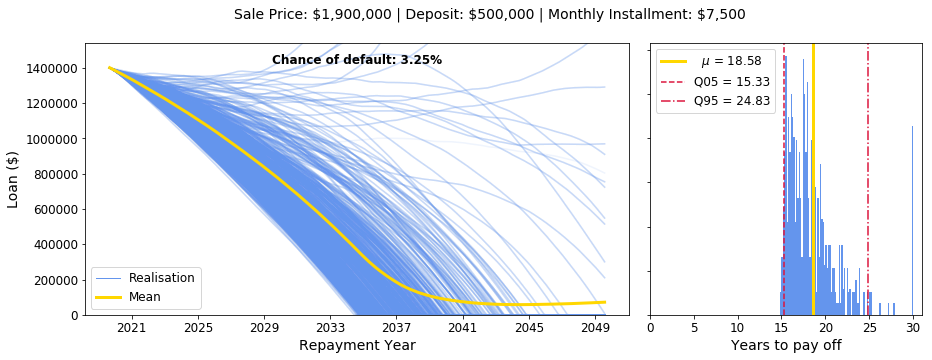

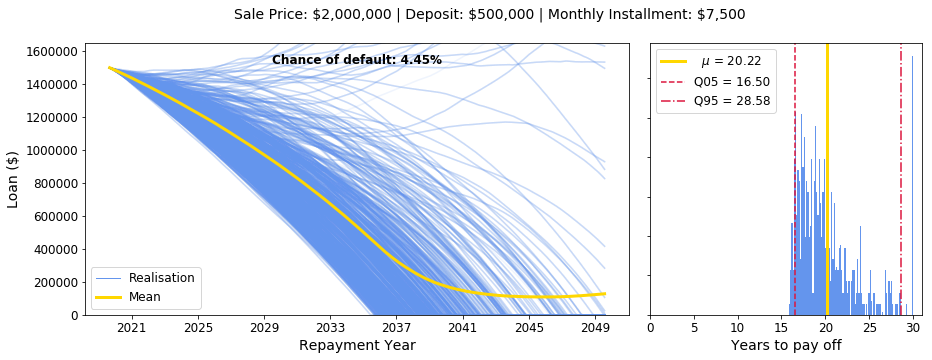

CPU times: user 44.6 s, sys: 1.55 s, total: 46.2 s
Wall time: 3min 48s


In [69]:
%%time
for sale_price in np.linspace(1e6, 2.0e6, 11):
    simulate_mortgage(sale_price, 500e3, 7500, simlen=2000)